In [1]:
wd <- dirname(dirname(getwd()))
source(paste0(wd,"/mission_control/treasure_map.R"))
source(paste0(wd,"/mission_control/helpers/figures/figure5_themes.R"))

library(tidyverse)
library(RColorBrewer)
library(gridExtra)
library(ggpubr)

library(survival)
library(survminer)
library(survcomp)

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  3.1.2     ✔ purrr   0.3.4
✔ tidyr   1.1.3     ✔ dplyr   1.0.6
✔ readr   1.3.1     ✔ stringr 1.4.0
✔ tibble  3.1.2     ✔ forcats 0.5.1
Warning message:
“package ‘tibble’ was built under R version 3.6.3”Warning message:
“package ‘tidyr’ was built under R version 3.6.3”Warning message:
“package ‘purrr’ was built under R version 3.6.3”Warning message:
“package ‘dplyr’ was built under R version 3.6.3”Warning message:
“package ‘forcats’ was built under R version 3.6.3”── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’

The following object is ma

#### Settings 

In [2]:
base_theme <- theme_classic(base_size = 31) 
theme <- (
    base_theme + 
    theme(plot.margin = unit(c(0,0,0,0), "cm"),
          legend.position="none", 
          axis.title.x = element_text(size = 20),
          axis.text.x = element_text(size = 15))
)
remove <- theme(axis.title.y=element_blank(), 
                axis.text.y=element_blank())
remove_x <- theme(axis.title.x=element_blank())

### 0 - read in validation data

In [3]:
fig5_data <- readRDS(paste0(TMP_DIR, "figure5_data.Rds"))

### 1 - Fit coxph models 

In [4]:
fits_lr <- list()
fits_os <- list()
for( i in names(fig5_data)){
    fits_lr[[i]] <- survfit(Surv(os_days/(365/12), os_event) ~ lr_gp, data = fig5_data[[i]])
}
for( i in names(fig5_data)){
    fits_os[[i]] <- survfit(Surv(os_days/(365/12), os_event) ~ os_gp, data = fig5_data[[i]])
}

### 2 - Make plots

In [5]:
ggsurvplot_facet2 <- function(pval.size = 5, ...)
{
  newcall <- bquote(
    p <- p + geom_text(data = pvals.df, aes(x = pval.x, y = pval.y, label = pval.txt), size = .(pval.size), hjust = 0)
    )

    body(ggsurvplot_facet)[[20]][[3]][[8]] <- newcall
    ggsurvplot_facet(...)
}
cols <- brewer.pal(6,"RdYlGn")[c(1,3,6)]
cols2 <- brewer.pal(6,"RdYlGn")[c(6,1,3)]

In [6]:
go_surv <- function(pts, i) {
    (
        ggsurvplot_facet2(pts[[i]], 
                          fig5_data[[i]], 
                          ggtheme = theme, 
                          xlab = "Months", 
                          ylab = "Survival Probability",
                          facet.by = "tissue", 
                          pval = TRUE, 
                          palette = cols2,
                          short.panel.labs=T,
                          pval.coord = c(15,.94), 
                          pval.size = 7) + theme(legend.position="none")
    )
}

#### Response Strata

In [7]:
plts_lr <- list()
plts_os <- list()
for( i in names(fig5_data)){
    plts_lr[[i]] <- go_surv(fits_lr, i)
    plts_os[[i]] <- go_surv(fits_os, i) #+ scale_x_continuous(breaks = c(0,10,20,50), limits = c(0,55))
}

Warning message:
“`as.tibble()` was deprecated in tibble 2.0.0.
Please use `as_tibble()` instead.
The signature and semantics have changed, see `?as_tibble`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”Warning message:
“`select_()` was deprecated in dplyr 0.7.0.
Please use `select()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”

#### Arrange and Share plots

In [8]:
plots_lr <- arrangeGrob(plts_lr$'HMF-CPCT', plts_lr$Melanoma + remove, plts_lr$Lung + remove, 
                         plts_lr$Bladder + remove, plts_lr$Other + remove, 
                         layout_matrix = rbind( c(1,1,2,3), c(1,1,4,5)))

In [9]:
plots_os <- arrangeGrob(plts_os$'HMF-CPCT' +remove_x, plts_os$Melanoma + remove, plts_os$Lung + remove, 
                         plts_os$Bladder + remove, plts_os$Other + remove, 
                         layout_matrix = rbind( c(1,1,2,3), c(1,1,4,5)))

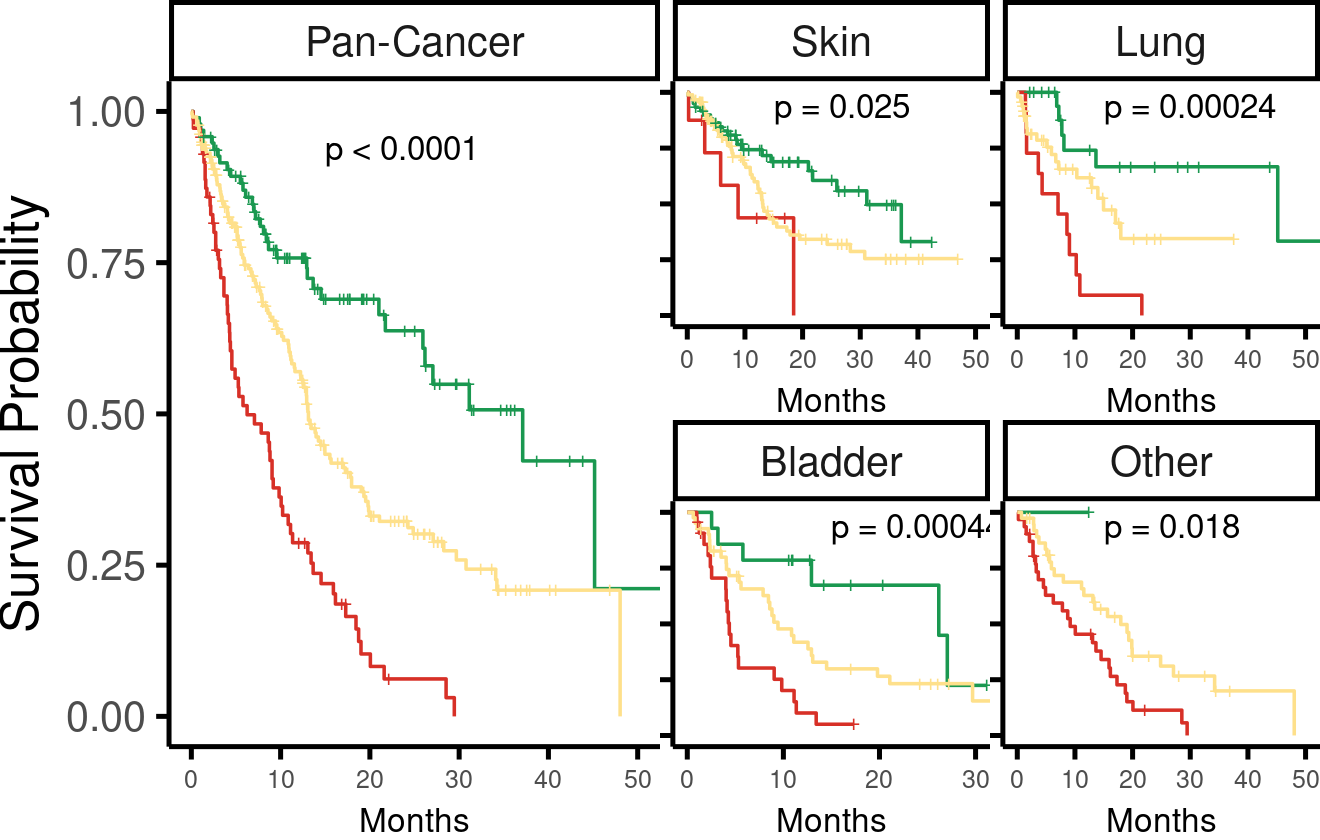

In [10]:
options(repr.plot.width=11, repr.plot.height=7, resolution = 500)
plot(plots_lr)

####  Survival strata

In [12]:
saveRDS( list( "response" = plots_lr , "survival" = plots_os), file = paste0(FIG_DIR, "figure5_c.Rds") )